# Machine Learning Coursework 

*For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.*

## 1. Exploratory Data Analysis

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

In [2]:
# Begin by examining the dataset
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### 1.1. Visualising the data

In [435]:
# define plotting function
def myplotGrid(X,y):
    """Plots pairwise scatter graphs of the selected features, colour coded by the wine
    classification (y-input). Plots histograms on the diagonals.
    
    Parameters
    ----------
    X = numpy array of features
    y = numpy array of classifications
    
    Returns
    -------
    n x n grid of graphs, where n is the number of selected features.
    """
    xlabels = [13,14,15,16]
    ylabels = [0,4,8,12]
    fig = plt.figure(figsize=(16,16))
    n = 0
    for i in range(0,len(selected_features)):
        for j in range(0,len(selected_features)):
        # Create nxn subplot where n is the number of features,
        # and cycle through each subplot to add the graph:
            ax = fig.add_subplot(len(selected_features),len(selected_features),n+1) 
            # Remove top and righthand frames from subplots:
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            # Plot a histogram on the diagonal subplots:
            if i == j:
                for f in range(0,len(selected_features)):
                    plt.hist(X[:,i][np.where(y == f)], alpha = 0.5)
            else:
            # Plot scatter graphs elsewhere:
                ax.scatter(X[:, j], X[:, i], c=y, cmap=plt.cm.Paired)
            # Add labels to the left hand side and the bottom of the overall plot,
            # remove ticks from the inner subplots:
            if n+1 in xlabels:
                ax.set_xlabel(selected_features[j])
            if n+1 not in xlabels:
                ax.set_xticks([])
            if n in ylabels:
                ax.set_ylabel(selected_features[i])
            if n not in ylabels:
                ax.set_yticks([])
            n+=1                    # Increase n in order to move onto the next subplot
    plt.show()

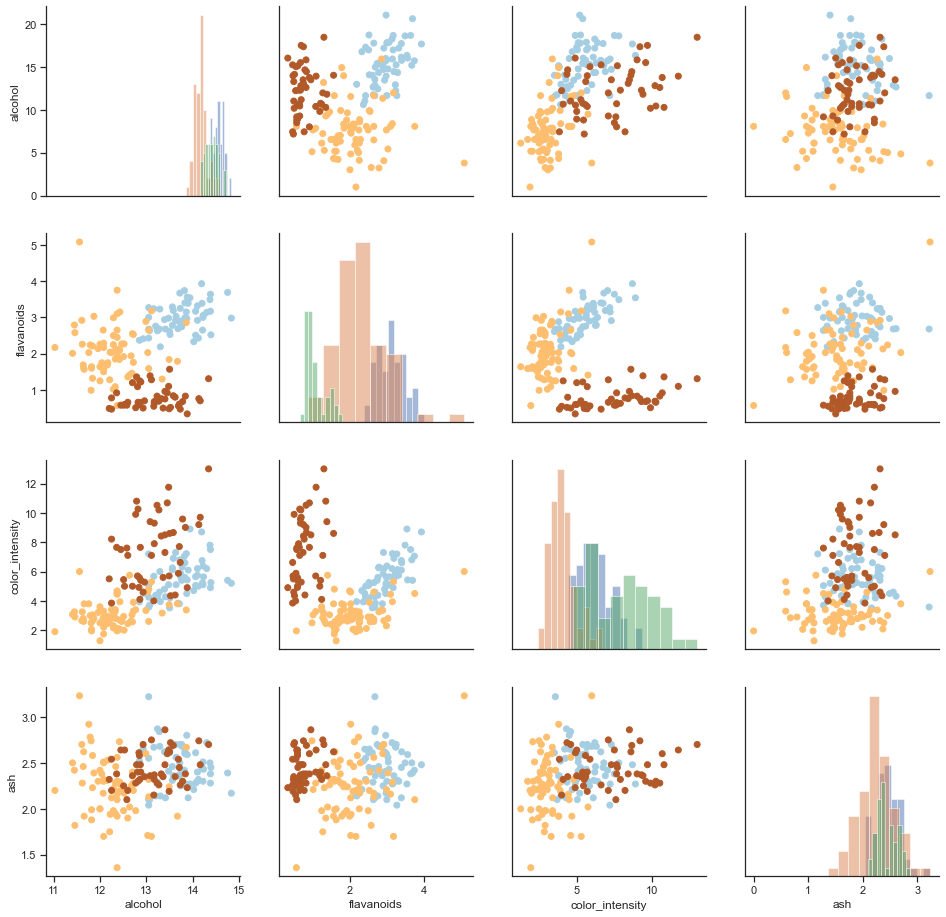

In [436]:
# run the plotting function

myplotGrid(X,y)

## 2. Implementing kNN

*In the cell below, develop your own code for performing k-Nearest Neighbour classification.  It is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions.*

In [453]:
# Create random indices in order to split the data into test and training sets.
indices = np.random.permutation(len(y))
bins=np.array_split(indices, 5)     # Split the indices into 5 bins.
X_train_indices = []
for i in range(1,5):                # Use four of the bins to create the training data
    X_train_indices.append(bins[i])
X_train_indices = np.concatenate(X_train_indices)
X_test_indices = bins[0]            # Use the first (unused) bin to create the test data
y_train_indices = []                # Repeat the process for the y (target) data
for i in range(1,5):
    y_train_indices.append(bins[i])
y_train_indices = np.concatenate(y_train_indices)
y_test_indices = bins[0]
X_train = X[X_train_indices]        # Get the training and testing data using the lists of
X_test = X[X_test_indices]          # indices created above
Y_train = y[y_train_indices]
Y_test = y[y_test_indices]

In [562]:
def distance_calculator(training_data, test_data, distance):
    """ Calculates distances between two sets of data. Distance metric used
    depends on distance input.
    
    Parameters
    ----------
    training_data = numpy array of training data
    test_data = numpy array of test data
    distance:
        'chebyshev' - Chebyshev distance
        'euclidean' - Euclidean distance
        'manhattan' - Manhattan distance
    
    Returns
    -------
    List of the distances between all of the points in the training data and
    all of the points in the test data.
    """
    dist=[]
    if distance == 'euclidean':
        for a in test_data:
            x = ((training_data-a)**2)
            y = (np.sqrt(np.sum(x, axis = 1)))
            dist.append(y)
        return dist
    elif distance == 'manhattan':
        for a in test_data:
            x = np.abs(training_data-a)
            y = (np.sum(x, axis = 1))
            dist.append(y)
    elif distance == 'chebyshev':
        for a in test_data:
            x = np.abs(training_data-a)
            y = (np.max(x, axis = 1))
            dist.append(y)
    return dist

In [563]:
def neighbours(training_data,test_data,k,distance):
    """ Uses the distance calculator function to find the k nearest neighbours
    in the trainig data to each point in the test data.
    
    Parameters
    ----------
    training_data = numpy array of training data
    test_data = numpy array of test data
    k = number of nearest neighbours to use for classification
    distance:
        'chebyshev' - Chebyshev distance
        'euclidean' - Euclidean distance
        'manhattan' - Manhattan distance
    
    Returns
    -------   
    A tuple containing two lists:
    (1) Numpy arrays of the distances of the closest neighbours.
    (2) Numpy arrays of the indices of these neighbours.
    
    """
    d = distance_calculator(training_data, test_data, distance)
    sorted_values = []
    sorted_indexes = []
    # Add the values to the lists, sort them from closest to furthest,
    # and then cut the lists so that they contain only k points.
    for e in d:
        sl = np.array(sorted(e)[:k])
        sorted_values.append(sl)
        sorted_indexes.append(np.argsort(e)[:k])
    return sorted_values, sorted_indexes

In [564]:
# mykNN code
def mykNN(X,y,X_,k,distance):
    """Predicts the class of the test data.
        
    Parameters
    ----------
    X = numpy array of training data
    y = numpy array of correct classes for the training data
    X_ = numpy array of test data
    k = number of nearest neighbours to use for classification
    distance:
        'chebyshev' - Chebyshev distance
        'euclidean' - Euclidean distance
        'manhattan' - Manhattan distance
    
    Returns
    -------   
    Numpy array containing the predicted classes for the test data.
    
    """
    possible_classifications = []
    sorted_values, sorted_indexes = neighbours(X,X_,k,distance)
    # Get a list of the correct classes for the k nearest neighbours:
    for index in sorted_indexes:
        sc = np.array(y[index])
        possible_classifications.append(sc)
    # Convert possible classifications from a list of numpy arrays to a list of lists.
    possible_classifications = [l.tolist() for l in possible_classifications]
    # Create a list of dictionaries, with keys being the class and values being the
    # total count for that class.
    classification_counts = []
    for p in possible_classifications:            
        unique, counts = np.unique(p, return_counts=True)
        classification_counts.append(dict(zip(unique, counts)))
    # Create a list of the predicted classifications.
    new_list=[]
    for c in classification_counts:
        count = 0
        temp_list=[]
        for item, value in c.items():
            if value > count:            #Cycle through each element in the dictionaries and add the
                temp_list = []           # element with the highest count to the temporary list.
                temp_list.append(item)
                count = value
            elif value == count:         # If two counts have an equally high value, add both to the
                temp_list.append(item)   # temporary list.
        new_list.append(temp_list)
    # Deal with tie break situations where the nearest neighbours are more than one class.
    for i in range(0,len(new_list)-1):   
        if len(new_list[i]) > 1:
            temp_list = []
            # Use a new temporary list to gather the distances for the competing points.
            for e in new_list[i]:        
                temp_list.append(possible_classifications[i].index(e))
            correct_index = min(temp_list)    # Keep the closest point
            # Replace the original sublist with the single class of the closest of the competing points.
            new_list[i] = [possible_classifications[i][correct_index]]           
    y_pred = []
    for item in new_list:                # Change the list of lists into one numpy array.
        for x in item:
            y_pred.append(x)
    return np.array(y_pred)

In [565]:
y_pred = mykNN(X_train, Y_train, X_test, 10, 'euclidean')
print("Actual values:    {}".format(Y_test))
print("Predicted valyes: {}".format(y_pred))

Actual values:    [1 2 2 0 0 2 0 0 2 2 0 0 1 2 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 2 1 2 0 1 1 1]
Predicted valyes: [1 2 2 0 0 2 0 0 2 2 0 0 1 2 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 2 1 2 0 1 1 1]


We can check that the mykNN is working correctly by comparing it with the scikit-learn implementation of k-nearest-neighbours:

In [639]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


knn=KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train,Y_train)
y_pred_model=knn.predict(X_test)

print("Actual values:                 {}".format(Y_test))
print("mykNN predicted valyes:        {}".format(y_pred))
print("Scikit-learn predicted valyes: {}".format(y_pred_model))

Actual values:                 [1 2 2 0 0 2 0 0 2 2 0 0 1 2 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 2 1 2 0 1 1 1]
mykNN predicted valyes:        [1 2 2 0 0 2 0 0 2 2 0 0 1 2 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 2 1 2 0 1 1 1]
Scikit-learn predicted valyes: [1 2 2 0 0 2 0 0 2 2 0 0 1 2 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 2 1 2 0 1 1 1]


As we can see, mykNN returns the same predicted values as the scikit-learn model, and almost exactly the same values as the actual (test) data.

## 3. Classifier evaluation

*In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy.*


In [567]:
def myConfMat(y_test,y_pred,classno):
    """ Returns a basic confusion matrix for kNN.
    
    Parameters
    ----------
    y_test = target test data (correct classifications)
    y_pred = predictions made by mykNN (or other k-nearest neighbour algorithm)
    classno = number of distinct classes in the target data
    
    Returns
    -------
    Confusion matrix with predicted values as the columns and actual values
    as the rows.
    """
    C = np.zeros(shape=(classno,classno))
    for i in range(0,len(y_pred)):
        C[y_test[i],y_pred[i]]+=1
    return C

In [568]:
myConfMat(Y_test,y_pred,len(np.unique(y)))

array([[12.,  0.,  0.],
       [ 1., 15.,  0.],
       [ 0.,  0.,  8.]])

In [569]:
def myConfMatClean(y_test,y_pred,classno):
    """ Returns a confusion matrix for kNN, with added labels and styling.
    
    Parameters
    ----------
    y_test = target test data (correct classifications)
    y_pred = predictions made by mykNN (or other k-nearest neighbour algorithm)
    classno = number of distinct classes in the target data
    
    Returns
    -------
    Labelled confusion matrix.
    """
    C = myConfMat(Y_test,y_pred,classno).astype(int)
    confusion_matrix = pd.DataFrame(C, index = ['Actual 0','Actual 1','Actual 2'], 
                                    columns = ['Predicted 0', 'Predicted 1', 'Predicted 2'])
    return  confusion_matrix.style.background_gradient()

In [570]:
myConfMatClean(Y_test,y_pred,3)

,Predicted 0,Predicted 1,Predicted 2
Actual 0,12,0,0
Actual 1,1,15,0
Actual 2,0,0,8


In [571]:
def basic_accuracy(y_pred,y_test):
    """Calculates accuracy for knn algorithm.
    
    Parameters
    ----------
    y_pred = predictions made by mykNN (or other k-nearest neighbour algorithm)
    y_test = target test data (correct classifications)

    Returns
    -------
    Accuracy value between 0 and 1 (0 = no accuracy, 1 = 100% accurate).
    """
    correct = 0
    total = len(y_test)
    for i in range(0,total):
        if y_pred[i] == y_test[i]:
            correct+=1
    return correct/total

In [572]:
#Check the accuracy of mykNN, rounded to 2 decimal places:
round(basic_accuracy(y_pred, Y_test),2)

0.97

In [573]:
def overall_accuracy(matrix):
    """Calculates accuracy for knn algorithm.
    
    Parameters
    ----------
    matrix = confusion matrix for knn in the form of a numpy array.

    Returns
    -------
    Accuracy value between 0 and 1 (0 = no accuracy, 1 = 100% accurate).
    """    
    correct = 0
    total = 0
    for i in range(0,3):
        correct+= confusion_matrix[i][i]
        for j in range(0,3):
            total+=confusion_matrix[i][j]
    return correct/total
    
def recall(matrix):
    """Calculates recall (per class accuracy) for each class for knn algorithm
    (likeliness that the knn algorithm will predict the correct class).
    
    Parameters
    ----------
    matrix = confusion matrix for knn in the form of a numpy array.

    Returns
    -------
    Recall value between 0 and 1 (0 = no accuracy, 1 = 100% accuracy).
    """ 
    zero_recall = matrix[0][0]/(matrix[0][0]+matrix[0][1]+matrix[0][2])
    one_recall = matrix[1][1]/(matrix[1][1]+matrix[1][0]+matrix[1][2])
    two_recall = matrix[2][2]/(matrix[2][2]+matrix[2][0]+matrix[2][1])
    return zero_recall, one_recall, two_recall

def precision(matrix):
    """Calculates precision for each class for knn algorithm
    (likeliness that the knn algorithm prediction will be correct).
    
    
    Parameters
    ----------
    matrix = confusion matrix for knn in the form of a numpy array.

    Returns
    -------
    Precision value between 0 and 1 (0 = no accuracy, 1 = 100% accuracy).
    """ 
    zero_p = matrix[0][0]/(matrix[0][0]+matrix[1][0]+matrix[2][0])
    one_p = matrix[1][1]/(matrix[1][1]+matrix[0][1]+matrix[2][1])
    two_p = matrix[2][2]/(matrix[2][2]+matrix[0][2]+matrix[1][2])
    return zero_p, one_p, two_p

In [574]:
def accuracy_measures(matrix):
    """Function to print out the three main evaluation metric with single input"""
    print("Overall Accuracy: {}".format(overall_accuracy(matrix)))
    print('\n')
    print("Class 0 Recall: {}".format(round(recall(matrix)[0]),2))
    print("Class 1 Recall: {}".format(recall(matrix)[1]))
    print("Class 2 Recall: {}".format(recall(matrix)[2]))
    print('\n')
    print("Class 0 Precision: {}".format(precision(matrix)[0]))
    print("Class 1 Precision: {}".format(precision(matrix)[1]))
    print("Class 2 Precision: {}".format(precision(matrix)[2]))

In [575]:
confusion_matrix = myConfMat(Y_test,y_pred,len(np.unique(y)))
accuracy_measures(confusion_matrix)

Overall Accuracy: 0.9722222222222222


Class 0 Recall: 1
Class 1 Recall: 0.9375
Class 2 Recall: 1.0


Class 0 Precision: 0.9230769230769231
Class 1 Precision: 1.0
Class 2 Precision: 1.0


We can check that these accuracy functions are operating correctly by using the scikit-learn metrics score methods.

In [576]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("sklearn Overall Accuracy: {}".format(accuracy_score(Y_test,y_pred)))
print('\n')
print("sklearn Class 0 Recall: {}".format(recall_score(Y_test,y_pred,average=None)[0]))
print("sklearn Class 1 Recall: {}".format(recall_score(Y_test,y_pred,average=None)[1]))
print("sklearn Class 2 Recall: {}".format(recall_score(Y_test,y_pred,average=None)[2]))
print('\n')
print("sklearn Class 0 Precision: {}".format(precision_score(Y_test,y_pred,average=None)[0]))
print("sklearn Class 1 Precision: {}".format(precision_score(Y_test,y_pred,average=None)[1]))
print("sklearn Class 2 Precision: {}".format(precision_score(Y_test,y_pred,average=None)[2]))

sklearn Overall Accuracy: 0.9722222222222222


sklearn Class 0 Recall: 1.0
sklearn Class 1 Recall: 0.9375
sklearn Class 2 Recall: 1.0


sklearn Class 0 Precision: 0.9230769230769231
sklearn Class 1 Precision: 1.0
sklearn Class 2 Precision: 1.0


As we can see, scikit-learn returns the same scores as my accuracy functions. We can also add these to a table (pandas dataframe) in order to compare them side by side:

In [577]:
a = pd.Series([overall_accuracy(confusion_matrix), accuracy_score(Y_test,y_pred)], index = ['myKnn Accuracy', 'sklearn Accuracy'])
b = pd.Series([recall(confusion_matrix)[0], recall_score(Y_test,y_pred,average=None)[0]], index = ['myKnn Accuracy', 'sklearn Accuracy'])
c = pd.Series([recall(confusion_matrix)[1], recall_score(Y_test,y_pred,average=None)[1]], index = ['myKnn Accuracy', 'sklearn Accuracy'])
d = pd.Series([recall(confusion_matrix)[2], recall_score(Y_test,y_pred,average=None)[2]], index = ['myKnn Accuracy', 'sklearn Accuracy'])
e = pd.Series([precision(confusion_matrix)[0], precision_score(Y_test,y_pred,average=None)[0]], index = ['myKnn Accuracy', 'sklearn Accuracy'])
f = pd.Series([precision(confusion_matrix)[1], precision_score(Y_test,y_pred,average=None)[1]], index = ['myKnn Accuracy', 'sklearn Accuracy'])
g = pd.Series([precision(confusion_matrix)[2], precision_score(Y_test,y_pred,average=None)[2]], index = ['myKnn Accuracy', 'sklearn Accuracy'])

In [578]:
metrics_comparison = pd.DataFrame([a,b,c,d,e,f,g], index = ["Accuracy", "Recall 0", "Recall 1", "Recall 2", "Precision 0", "Precision 1", "Precision 2"])
metrics_comparison.T

,Accuracy,Recall 0,Recall 1,Recall 2,Precision 0,Precision 1,Precision 2
myKnn Accuracy,0.972222,1.0,0.9375,1.0,0.923077,1.0,1.0
sklearn Accuracy,0.972222,1.0,0.9375,1.0,0.923077,1.0,1.0



## 4. Nested Cross-validation using your implementation of KNN

*In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. Your function should return a list of accuracies per fold. For each fold, your function should print: (a) the accuracy per distinct set of parameters on the validation set, (b) the best set of parameters for the fold after validation, and (c) the confusion matrix per fold (on the testing set).*

In [614]:
def myNestedCrossVal(X,y,nFolds,kvals,distances,mySeed):
    """ Invokes mykNN and performs nested cross validation for a range of k parameters
    and up to three distance parameters, over a specified number of folds.
    
    Parameters
    ----------
    X = numpy array of features
    y = numpy array of classifications
    nFolds = integer number of folds to use for training
    kvals = a list of integer numbers to use as the k parameter
    distance = a list of up to three of the following:
        'chebyshev' - Chebyshev distance
        'euclidean' - Euclidean distance
        'manhattan' - Manhattan distance
    mySeed = a random seed integer used to create the data splits
    
    Prints
    ------
    The accuracy score for every combination of k value and distance measure for the
    inner loop of each fold.
    The best performing k value and distance measure for the inner loop of each fold.
    The confusion matrix for each fold using the best set of parameters for that fold.
    The fold accuracies for each fold using the best set of parameters for that fold.
    
    Returns
    -------
    A tuple containing:
    (1) Accuracy fold = a list of the accuracy scores of each fold using the best set of
                        parameters for that fold based on the nested parameter evaluation.
    (2) Matrix List = a list of confusion matrices corresponding the results in the accuracy fold.
    """
    accuracy_fold=[]
    matrix_list = []
    # Create random indices in order to split the data into test and training folds.
    np.random.seed(mySeed)
    indices = np.random.permutation(np.arange(0,len(X),1))
    indices = np.array_split(indices, nFolds)           # Split the indices into n x folds.
    for iFold in range(0,nFolds):
        print('\033[91m\033[4m\033[1mNEW ITERRATION\033[0m\033[0m\033[0m')
        print('\n')
        testFold = indices[iFold]                       # Use one set of indices at a time to create test data. 
        trainFold=[]
        for j in range(0,nFolds):                       # Use the remaining indices to create training data.
            if j!=iFold:
                trainFold.extend(indices[j])
        # Create the test and training data using the test and training indices.
        X_train, X_test = X[trainFold], X[testFold]
        y_train, y_test = y[trainFold], y[testFold]
        # Create a random permutation of the indices of the training data.
        loop_indices = np.random.permutation(trainFold)
        loop_indices = np.array_split(loop_indices, 5)  # Split the indices into 5 bins.
        test_loop_fold = loop_indices[0]                # Use the first bin to form the validation data.
        train_loop_fold = []
        for i in range(1,5):                            # Use the remaining bins to form the training data.
            train_loop_fold.extend(loop_indices[i])
        # Create the validation and training data using the indices.
        X_loop_train, X_loop_test = X[train_loop_fold], X[test_loop_fold]
        y_loop_train, y_loop_test = y[train_loop_fold], y[test_loop_fold]
        accuracy_list = []
        current_result = 0
        # For each k value and distance measure entered, calculate the accuracy of mykNN on the
        # 'X_loop_train' training data for each of the folds.
        for k in kvals:
            for d in distances:
                result = basic_accuracy(mykNN(X_loop_train,y_loop_train,X_loop_test,k,d),y_loop_test)
                # Add the best perfoming k and distance measure along with their accuracy
                # to the accuracy list.
                if result > current_result:             
                    accuracy_list = []
                    accuracy_list.append([k,d,result])
                    current_result = result
                print("K = {} | Distance = {} | Accuracy = {}".format(k, d, result))
        print('\n')
        print("\033[1mFor fold {}, the best value for k is \033[4m{}\033[0m\033[1m and the best \
distance measure is \033[4m{}\033[0m\033[0m.".format(iFold+1,accuracy_list[0][0],accuracy_list[0][1])) 
        # Use the accuracy list to get the best performing parameters for the current fold.
        # Evaluate the performance of the fold on the (larger) training set with those parameters.
        # Add the accuracy scores to the accuracy fold list.
        accuracy_fold.append(basic_accuracy(mykNN(X_train,y_train,X_test,
                                                  accuracy_list[0][0],accuracy_list[0][1]),y_test))
        print('\n')  
        # Create and add to a list the confusion matrix for each fold using the best parameters.
        matrix_list.append(myConfMat(y_test, mykNN(X_train,y_train,X_test,accuracy_list[0][0],
                                                   accuracy_list[0][1]),len(np.unique(y))))
    
        print("Confusion Matrix for fold {}:".format(iFold+1), '\n', myConfMat(y_test, 
                    mykNN(X_train,y_train,X_test,accuracy_list[0][0],accuracy_list[0][1]),len(np.unique(y))))
        print('\n')
    print("Fold accuracies using the best parameters for each fold: {}".format(accuracy_fold))
    
    return(accuracy_fold, matrix_list)

In [648]:
# evaluate clean data code
print('CLEAN')
# Use the first item in the tuple returned by myNestedCrossVal to get the accuracy of each fold:
clean_accuracy_folds = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean', 'manhattan','chebyshev'],mySeed)[0]
avg_clean_accuracy = np.mean(clean_accuracy_folds)
# Return the sample accuracy (rather than population accuracy):
sd_clean_accuracy = np.std(clean_accuracy_folds, ddof=1)
print('\n')
print("Average accuracy across all folds for clean data = {}".format(avg_clean_accuracy))
print('\n')
print("Sample standard deviation across all folds for clean data = {}".format(sd_clean_accuracy))

CLEAN
NEW ITERRATION


K = 1 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 1 | Distance = manhattan | Accuracy = 0.896551724137931
K = 1 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 2 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 2 | Distance = manhattan | Accuracy = 0.896551724137931
K = 2 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 3 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 3 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 3 | Distance = chebyshev | Accuracy = 0.896551724137931
K = 4 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 4 | Distance = manhattan | Accuracy = 0.896551724137931
K = 4 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 5 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 5 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 5 | Distance = chebyshev | Accuracy = 0.9655172413793104
K = 6 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 6

K = 7 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 8 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 8 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 8 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 9 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 9 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 9 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 10 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 10 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 10 | Distance = chebyshev | Accuracy = 0.9310344827586207


For fold 5, the best value for k is 1 and the best distance measure is euclidean.


Confusion Matrix for fold 5: 
 [[ 9.  0.  0.]
 [ 1. 14.  0.]
 [ 0.  1. 10.]]


Fold accuracies using the best parameters for each fold: [0.9722222222222222, 0.9166666666666666, 0.9444444444444444, 0.8857142857142857, 0.9428571428571428]


Average accuracy across all folds for clean data = 0.932380952

In [649]:
# evaluate noisy  data code
print('NOISY')
noisy_accuracy_folds = myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean', 'manhattan', 'chebyshev'],mySeed)[0]
avg_noisy_accuracy = np.mean(noisy_accuracy_folds)
sd_noisy_accuracy = np.std(noisy_accuracy_folds, ddof=1)
print('\n')
print("Average accuracy across all folds for noisy data = {}".format(avg_noisy_accuracy))
print('\n')
print("Sample standard deviation across all folds for noisy data = {}".format(sd_noisy_accuracy))

NOISY
NEW ITERRATION


K = 1 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 1 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 1 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 2 | Distance = euclidean | Accuracy = 0.9655172413793104
K = 2 | Distance = manhattan | Accuracy = 0.9655172413793104
K = 2 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 3 | Distance = euclidean | Accuracy = 0.9655172413793104
K = 3 | Distance = manhattan | Accuracy = 0.9655172413793104
K = 3 | Distance = chebyshev | Accuracy = 1.0
K = 4 | Distance = euclidean | Accuracy = 0.9655172413793104
K = 4 | Distance = manhattan | Accuracy = 0.9655172413793104
K = 4 | Distance = chebyshev | Accuracy = 1.0
K = 5 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 5 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 5 | Distance = chebyshev | Accuracy = 1.0
K = 6 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 6 | Distance = manhattan | Accuracy = 0.93

K = 5 | Distance = manhattan | Accuracy = 0.896551724137931
K = 5 | Distance = chebyshev | Accuracy = 0.896551724137931
K = 6 | Distance = euclidean | Accuracy = 0.896551724137931
K = 6 | Distance = manhattan | Accuracy = 0.896551724137931
K = 6 | Distance = chebyshev | Accuracy = 0.8620689655172413
K = 7 | Distance = euclidean | Accuracy = 0.896551724137931
K = 7 | Distance = manhattan | Accuracy = 0.896551724137931
K = 7 | Distance = chebyshev | Accuracy = 0.8620689655172413
K = 8 | Distance = euclidean | Accuracy = 0.896551724137931
K = 8 | Distance = manhattan | Accuracy = 0.896551724137931
K = 8 | Distance = chebyshev | Accuracy = 0.8620689655172413
K = 9 | Distance = euclidean | Accuracy = 0.896551724137931
K = 9 | Distance = manhattan | Accuracy = 0.896551724137931
K = 9 | Distance = chebyshev | Accuracy = 0.896551724137931
K = 10 | Distance = euclidean | Accuracy = 0.896551724137931
K = 10 | Distance = manhattan | Accuracy = 0.896551724137931
K = 10 | Distance = chebyshev | Acc

It can be seen in the results of the nested cross validation that for each fold, there are numerous values of k and distance metrics that give the highest accuracy. The function (myNestedCrossVal) returns the first of these highest values that it finds.

A better approach may be to take the average scores of all k values and distances across each of the 5 folds. So we will take the average score for k = 1 with Euclidean, the average score for k = 2 with Euclidean, and so on. From here, we can select the best best overall k-distance combination and evaluate the algorithm using these parameters on the training data for each of the 5 folds.

This is implemented in the modified nested cross validation function below.

In [672]:
def myNestedCrossVal2(X,y,nFolds,kvals,distances,mySeed):
    """ Invokes mykNN and performs nested cross validation for a range of k parameters
    and up to three distance parameters, over a specified number of folds. Use the best performing
    parameters (on average) to evaluate the overall training data.
    
    Parameters
    ----------
    X = numpy array of features
    y = numpy array of classifications
    nFolds = integer number of folds to use for training
    kvals = a list of integer numbers to use as the k parameter
    distance = a list of up to three of the following:
        'chebyshev' - Chebyshev distance
        'euclidean' - Euclidean distance
        'manhattan' - Manhattan distance
    mySeed = a random seed integer used to create the data splits
    
    Prints
    ------
    The overall best perfoming parameters (on average) across the total folds, along with the
    average accuracy for these parameters.
    The fold accuracies for each fold using the overall best performing set of parameters.
    
    Returns
    -------
    Accuracy fold = a list of the accuracy scores of each fold using the best performing
                    set of parameters.
    """
    accuracy_fold=[]
    accuracy_list = []
    # Create random indices in order to split the data into test and training folds.
    np.random.seed(mySeed)
    indices = np.random.permutation(np.arange(0,len(X),1))
    indices = np.array_split(indices, nFolds)           # Split the indices into n x folds.
    for iFold in range(0,nFolds):
        testFold = indices[iFold]                       # Use one set of indices at a time to create test data. 
        trainFold=[]
        for j in range(0,nFolds):                       # Use the remaining indices to create training data.
            if j!=iFold:
                trainFold.extend(indices[j])
        # Create the test and training data using the test and training indices.
        X_train, X_test = X[trainFold], X[testFold]
        y_train, y_test = y[trainFold], y[testFold]
        loop_indices = np.random.permutation(trainFold)
        loop_indices = np.array_split(loop_indices, 5)  # Split the indices into 5 bins.
        test_loop_fold = loop_indices[0]                # Use the first bin to form the validation data.
        train_loop_fold = []
        for i in range(1,5):                            # Use the remaining bins to form the training data.
            train_loop_fold.extend(loop_indices[i])
        # Create the validation and training data using the indices.
        X_loop_train, X_loop_test = X[train_loop_fold], X[test_loop_fold]
        y_loop_train, y_loop_test = y[train_loop_fold], y[test_loop_fold]
        # For each k value and distance measure entered, calculate the accuracy of mykNN on the
        # 'X_loop_train' training data for each of the folds.
        for k in kvals:
            for d in distances:
                result = basic_accuracy(mykNN(X_loop_train,y_loop_train,X_loop_test,k,d),y_loop_test)
                # Add the best perfoming k and distance measure along with their accuracy
                # to the accuracy list.
                accuracy_list.append([k,d,result])
    # Create an empty list and add to it all of the results for the first fold:
    avg_param_list = []
    for n in range(0,len(distances)*len(kvals)):
        avg_param_list.append(accuracy_list[n])
    # Find every subsequent matching k-distance pair in the accuracy list and add the accuracy score
    # to the corresponding pair in the avg_param_list:
    for n in range(0,len(distances)*len(kvals)):
        for p in range(1, nFolds):
            avg_param_list[n][2]+= accuracy_list[p*(len(distances) * len(kvals))+n][2]
    # Divide the total accuracy score for each k-distance pair by the number of folds to find the average:
    for q in range(0,len(distances)*len(kvals)):
        avg_param_list[q][2] /= nFolds
    # Cycle through every entry in the avg_param_list to find the one with the highest accuracy score
    # and add it to the best_param_list:
    count = 0
    best_param_list = []
    for n in range(0,len(avg_param_list)):
        if avg_param_list[n][2] > count:
            best_param_list = []
            best_param_list.append(avg_param_list[n][0])
            best_param_list.append(avg_param_list[n][1])
            best_param_list.append(avg_param_list[n][2])
            count = avg_param_list[n][2]
    print("The best performing parameters across each fold are k = {} and distance = {} \
with an average accuracy of {}%.".format(best_param_list[0],best_param_list[1],round(best_param_list[2]*100,2)))
    # Re-establish the training data and test data (now that the function has stepped out of the for loop):
    for iFold in range(0,nFolds):
        testFold = indices[iFold]
        trainFold=[]
        for j in range(0,nFolds):
            if j!=iFold:
                trainFold.extend(indices[j])
        X_train, X_test = X[trainFold], X[testFold]
        y_train, y_test = y[trainFold], y[testFold]
        # Use the best_param_list to evaluate the performance of each fold.
        # Add the accuracy scores to the accuracy fold list.
        accuracy_fold.append(basic_accuracy(mykNN(X_train,y_train,X_test,
                    best_param_list[0],best_param_list[1]),y_test))
    print('\n')
    print("Fold accuracies using best parameters for each fold: {}".format(accuracy_fold))
    print('\n')
    print("Average accuracy for the model using these best parameters: {}%"
          .format(round((((np.sum(accuracy_fold))/nFolds)*100),2)))
    return(accuracy_fold)

In [673]:
myNestedCrossVal2(X,y,5,list(range(1,11)),['euclidean', 'manhattan', 'chebyshev'],mySeed)

The best performing parameters across each fold are k = 5 and distance = chebyshev with an average accuracy of 95.17%.


Fold accuracies using best parameters for each fold: [0.9722222222222222, 0.9166666666666666, 0.9444444444444444, 0.8571428571428571, 1.0]


Average accuracy for the model using these best parameters: 93.81%


[0.9722222222222222,
 0.9166666666666666,
 0.9444444444444444,
 0.8571428571428571,
 1.0]

In [674]:
myNestedCrossVal2(XN,y,5,list(range(1,11)),['euclidean', 'manhattan', 'chebyshev'],mySeed)

The best performing parameters across each fold are k = 7 and distance = euclidean with an average accuracy of 92.41%.


Fold accuracies using best parameters for each fold: [0.9444444444444444, 0.8888888888888888, 0.8611111111111112, 0.8571428571428571, 0.9714285714285714]


Average accuracy for the model using these best parameters: 90.46%


[0.9444444444444444,
 0.8888888888888888,
 0.8611111111111112,
 0.8571428571428571,
 0.9714285714285714]

We can see a slight improvement on the initial scores using this new function (**93.81%** accuracy versus **93.24%** for the clean data and **90.46%** versus **89.32%** for the noisy data).

### 5.2. Confusion matrix summary

*Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data).*


In [651]:
clean_confusion_matrices = (myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean', 'manhattan', 'chebyshev'],mySeed))[1]
noisy_confusion_matrices = (myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean', 'manhattan', 'chebyshev'],mySeed))[1]

NEW ITERRATION


K = 1 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 1 | Distance = manhattan | Accuracy = 0.896551724137931
K = 1 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 2 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 2 | Distance = manhattan | Accuracy = 0.896551724137931
K = 2 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 3 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 3 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 3 | Distance = chebyshev | Accuracy = 0.896551724137931
K = 4 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 4 | Distance = manhattan | Accuracy = 0.896551724137931
K = 4 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 5 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 5 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 5 | Distance = chebyshev | Accuracy = 0.9655172413793104
K = 6 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 6 | Dis

K = 6 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 6 | Distance = manhattan | Accuracy = 0.896551724137931
K = 6 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 7 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 7 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 7 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 8 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 8 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 8 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 9 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 9 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 9 | Distance = chebyshev | Accuracy = 0.9310344827586207
K = 10 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 10 | Distance = manhattan | Accuracy = 0.9310344827586207
K = 10 | Distance = chebyshev | Accuracy = 0.9310344827586207


For fold 5, the best value for k is 1 and the best distance measure is euclidean.

K = 7 | Distance = manhattan | Accuracy = 0.896551724137931
K = 7 | Distance = chebyshev | Accuracy = 0.8275862068965517
K = 8 | Distance = euclidean | Accuracy = 0.896551724137931
K = 8 | Distance = manhattan | Accuracy = 0.8620689655172413
K = 8 | Distance = chebyshev | Accuracy = 0.8620689655172413
K = 9 | Distance = euclidean | Accuracy = 0.9310344827586207
K = 9 | Distance = manhattan | Accuracy = 0.8620689655172413
K = 9 | Distance = chebyshev | Accuracy = 0.8620689655172413
K = 10 | Distance = euclidean | Accuracy = 0.896551724137931
K = 10 | Distance = manhattan | Accuracy = 0.8620689655172413
K = 10 | Distance = chebyshev | Accuracy = 0.8620689655172413


For fold 4, the best value for k is 9 and the best distance measure is euclidean.


Confusion Matrix for fold 4: 
 [[ 9.  2.  0.]
 [ 3. 13.  0.]
 [ 0.  0.  8.]]


NEW ITERRATION


K = 1 | Distance = euclidean | Accuracy = 0.896551724137931
K = 1 | Distance = manhattan | Accuracy = 0.8620689655172413
K = 1 | Distance = chebysh

In [668]:
def overall_cf(matrices):
    """Sums up multiple confusion matrices and use the 'precision and 'recall'
    functoins to add recall and precision values.
        
    Parameters
    ----------
    A list of numpy array confusion matrices.
    
    Returns
    -------
    A single pandas dataframe confusion matrix.
    """
    overall_matrix = np.zeros((matrices[0].shape))
    for m in matrices:
        for i in range(0,(len(matrices[0]))):
            for j in range(0,(len(matrices[0]))):
                overall_matrix[i][j] += m[i][j]
    pr = []
    for p in precision(overall_matrix):        # Get the precision values using the precision function.
        pr.append(round(p,2))
    rc = []
    for r in recall(overall_matrix):           # Get the recall values using the recall function.
        rc.append(round(r,2))
    # Convert the confusion matrix to a pandas dataframe and label the rows and columns:
    overall_matrix = (pd.DataFrame(overall_matrix, index = ['Actual 0','Actual 1','Actual 2'],
                        columns = ['Predicted 0', 'Predicted 1', 'Predicted 2']))
    # Add and populate a column for recall:
    overall_matrix['Recall'] = [rc[0], rc[1], rc[2]]
    # Append a row for precision:
    overall_matrix = overall_matrix.append(pd.DataFrame([[pr[0],pr[1],pr[2], '-']],
                        index = ['Precision'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Recall']))
    overall_matrix = overall_matrix.round(2)      # Round the values to two decimal places
    return overall_matrix

In [669]:
overall_cf(clean_confusion_matrices)

,Predicted 0,Predicted 1,Predicted 2,Recall
Actual 0,58.00,1.00,0.00,0.98
Actual 1,6.00,63.00,2.00,0.89
Actual 2,0.00,3.00,45.00,0.94
Precision,0.91,0.94,0.96,-


In [670]:
overall_cf(noisy_confusion_matrices)

,Predicted 0,Predicted 1,Predicted 2,Recall
Actual 0,50.00,8.00,1.00,0.85
Actual 1,7.00,62.00,2.00,0.87
Actual 2,0.00,1.00,47.00,0.98
Precision,0.88,0.87,0.94,-
